In [2]:
# On Colab: Need to upload catasto_rifugi.csv , comuni_catastali_amministrativi_trentino.csv
import geopandas as gpd
import pandas as pd
import os
import glob
import requests
import zipfile
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.simplefilter("ignore")

# Cadastral data
## Download 
Source: https://catastotn.tndigit.it/scarico-catasto-geometrico/it/index.html

In [4]:
# donwload_url = "https://catastotn.tndigit.it/export_semestrale_VL_PUBB/IDR0020230701_TIPOCATSH_CCXXX.zip"
# donwload_url = "https://catastotn.tndigit.it/export_semestrale_VL_PUBB/IDR0020240101_TIPOCATSH_CCXXX.zip"
download_url = "https://catastotn.tndigit.it/export_semestrale_VL_PUBB/IDR0020240701_TIPOCATSH_CCXXX.zip"
url_csv = "../data/catasto_rifugi.csv"

cadastre_huts_df = pd.read_csv(url_csv)
codici_catastali = cadastre_huts_df.codice_comune_catastale.unique()
codici_catastali

array([ 404,   44,  223,  439,  307,   66,  271,   94,  109,  429,  278,
        364,  302,  256,  247,  440,  286,  106,  353,  300,  263, -999,
        420,  258,  331,  272,  165,  125,  269])

In [5]:
# Request cadastral data for municipalities containing huts
gdflist = []
for codice in codici_catastali:
    codice = str(codice).zfill(3).replace(".0","")
    url = download_url.replace("XXX",codice)
    response = requests.get(url)
    # Elenca i nomi dei file che vuoi estrarre
    files_to_extract = []
    suffix = "_vl_uniqueparcel_poly"
    suffix = "_vl_parcel_poly"
    files_to_extract.append(codice + suffix + ".prj")
    files_to_extract.append(codice + suffix + ".shp")
    files_to_extract.append(codice + suffix + ".shx")
    files_to_extract.append(codice + suffix + ".dbf")
    if response.status_code == 200:
        with open("file.zip", "wb") as file:
            file.write(response.content)
        with zipfile.ZipFile("file.zip", "r") as zip_ref:
            for file_name in zip_ref.namelist():
                if file_name in files_to_extract:
                    zip_ref.extract(file_name)
        gdf = gpd.read_file(codice + suffix + ".shp")
        crs = gdf.crs
        gdflist.append(gdf)
        os.remove("file.zip")
        for shp in files_to_extract:
            os.remove(shp)
parcels = gpd.GeoDataFrame(pd.concat(gdflist, ignore_index=True), crs=crs)

In [6]:
parcels

,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry
0,P,141,404,N,YES,"POLYGON ((659366.399 5083222.897, 659376.619 5..."
1,P,142/1,404,N,YES,"POLYGON ((659384.01 5083211.905, 659379.344 50..."
2,P,143/1,404,N,YES,"POLYGON ((659384.01 5083211.905, 659370.14 508..."
3,P,4534,404,N,YES,"POLYGON ((659212.558 5083151.002, 659195.713 5..."
4,P,.906,404,N,YES,"POLYGON ((659361.867 5083203.976, 659370.14 50..."
...,...,...,...,...,...,...
188570,C,.408,269,S,YES,"POLYGON ((628368.96 5135187.904, 628369.048 51..."
188571,C,.409,269,S,YES,"POLYGON ((628211.709 5135183.252, 628214.739 5..."
188572,C,.413/1,269,S,YES,"POLYGON ((628232.885 5135250.9, 628226.315 513..."
188573,C,.678,269,S,YES,"POLYGON ((627311.949 5135149.424, 627321.812 5..."


<Axes: >

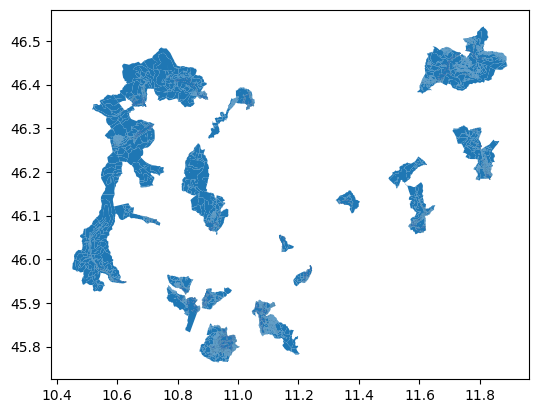

In [7]:
parcels = parcels.to_crs(epsg=4326)
parcels.plot()

I only use the parcels of the huts, which I know the codes (PT_CODE) from ../data/catasto_rifugi.csv, so I filter and save as a new dataframe

In [10]:
parcels_huts_df = pd.DataFrame()
for idx, rif in cadastre_huts_df.iterrows():
  rif_particella = parcels[(parcels['PT_CODE'] == rif['codice_part_ed']) & (parcels['PT_CCAT'] == rif['codice_comune_catastale'])]
  if not rif_particella.empty:
    parcels_huts_df = pd.concat([parcels_huts_df, rif_particella])
  else:
    print(rif['rifugio_nome'], "not found!") # should be only Tonini

Spruggio - "G.Tonini" not found!


Each hut is registered with multiple geometries for the same parcel code, we can plot them together to see the total area of the hut:

<Axes: >

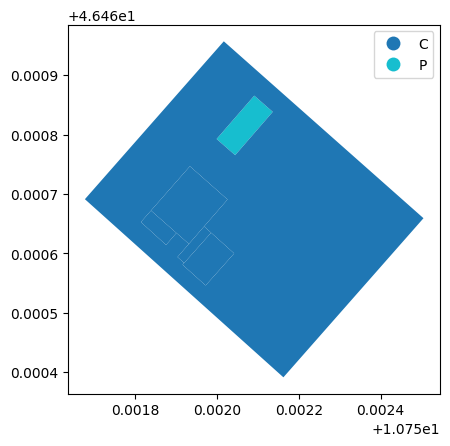

In [11]:
# Rifugio Dorigoni
parcels_huts_df[(parcels_huts_df['PT_CODE'] == "5239/2") & (parcels_huts_df['PT_CCAT'] == 300)].plot(column='PT_TYPE', legend=True)

<Axes: >

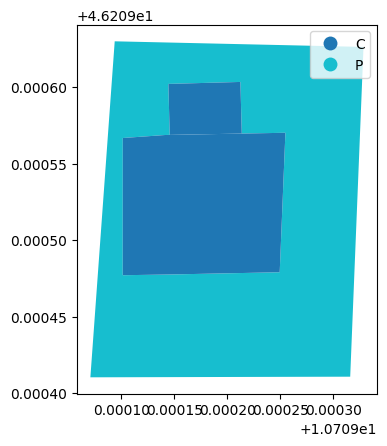

In [18]:
# Rifugio Segantini
parcels_huts_df[(parcels_huts_df['PT_CODE'] == ".145") & (parcels_huts_df['PT_CCAT'] == 165)].plot(column='PT_TYPE', legend=True)

In [12]:
# Save in a file (optional)
parcels_huts_df.to_file("../data/cad_parcels_huts.geojson")